# Testes e Treinamento

## Prequential Evaluation

Limpeza: Removendo espaços, identificadores (Flow ID, Timestamp, Umma,ed: 0) e colunas vazias...
Pré-processamento: Convertendo infinitos e preenchendo valores nulos...
Target: Processando coluna 'Label' como Binário (0=Normal, 1=Attack)...
Seleção de Features: Iniciando pipeline de redução de dimensionalidade...

--- Iniciando Processo de Seleção de Features (Total: 83) ---
Variância: 16 features removidas. Restantes: 67
Correlação (>0.95): 33 features redundantes removidas. Restantes: 34
Random Forest: Pular.
Features Finais (34) - ['Source Port_Entropy', 'Destination Port_Entropy', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Flow Bytes/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Min', 'Fwd IAT Mean', 'Bwd IAT Mean', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd Header Length', 'Bwd Header Length', 'Bwd Packe

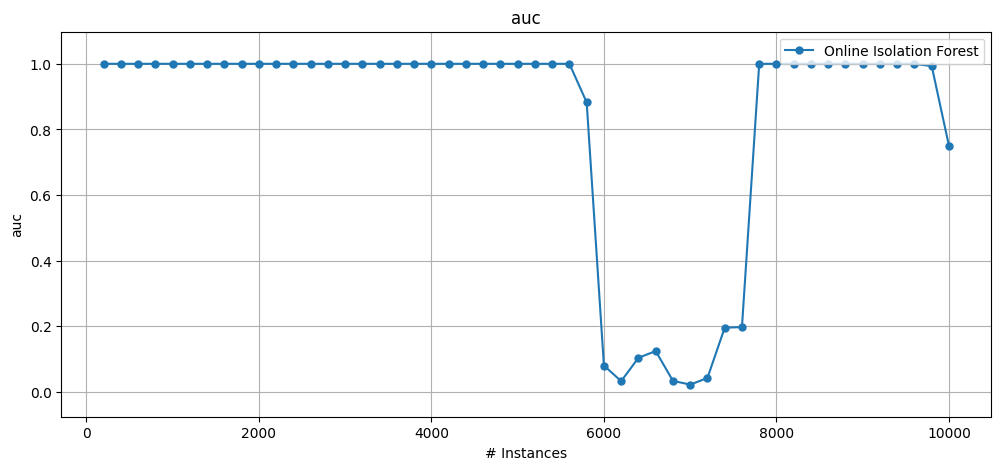

In [7]:
from capymoa.anomaly import OnlineIsolationForest
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.evaluation import prequential_evaluation_anomaly
from py.Streams import newStream
import pandas as pd

INICIO = 0
FIM = 10000
TOTAL_AMOSTRAS = FIM - INICIO
MAX_INSTANCES = TOTAL_AMOSTRAS

df = pd.read_csv(
    'datasets/CICDDoS2019/data/Exp_janela/SNMP_DNS_1s_0112.csv', 
    skiprows=range(1, INICIO), 
    nrows=TOTAL_AMOSTRAS
)

stream, target_names, feature_names = newStream(
    df=df, 
    target_label_col='Label', 
    binary_label=True, 
    normalize_method="MinMaxScaler", 
    threshold_var=0.75,
    threshold_corr=0.95,
    top_n_features=None,
    stream=True
)

oif = OnlineIsolationForest(schema=stream.get_schema())

results_oif = prequential_evaluation_anomaly(
    stream=stream, learner=oif, window_size=200
)

print(f"AUC: {results_oif.auc()}")
# display(results_oif.windowed.metrics_per_window())
plot_windowed_results(results_oif, metric="auc", save_only=False)

## Treinamento e Avaliação

Limpeza: Removendo espaços, identificadores (Flow ID, Timestamp, Umma,ed: 0) e colunas vazias...
Pré-processamento: Convertendo infinitos e preenchendo valores nulos...
Target: Processando coluna 'Label' como Binário (0=Normal, 1=Attack)...
Seleção de Features: Iniciando pipeline de redução de dimensionalidade...

--- Iniciando Processo de Seleção de Features (Total: 83) ---
Variância: 16 features removidas. Restantes: 67
Correlação (>0.95): 33 features redundantes removidas. Restantes: 34
Random Forest: Pular.
Features Finais (34) - ['Source Port_Entropy', 'Destination Port_Entropy', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Flow Bytes/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Min', 'Fwd IAT Mean', 'Bwd IAT Mean', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd Header Length', 'Bwd Header Length', 'Bwd Packe

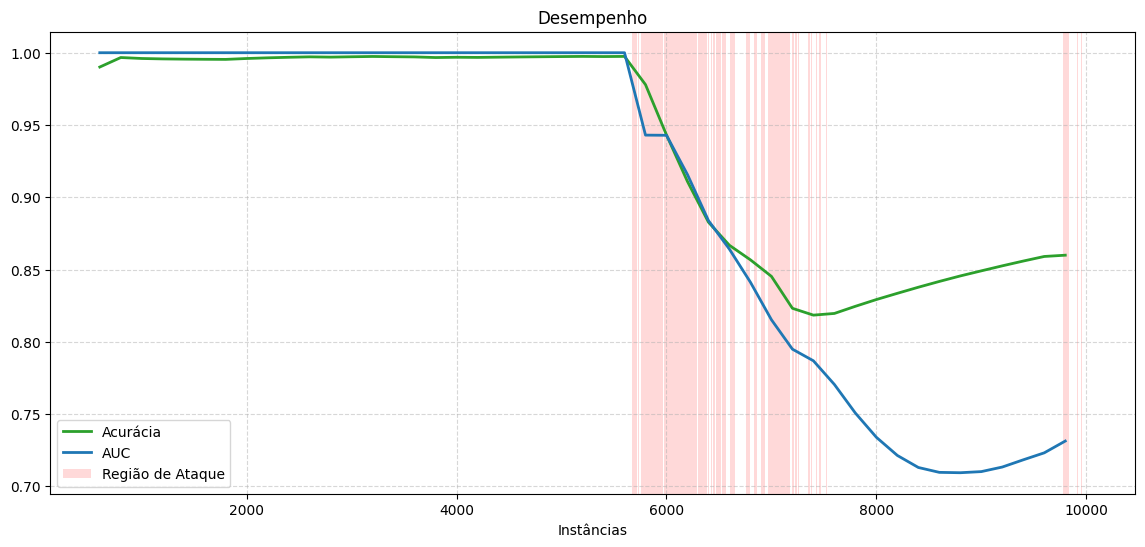

In [6]:
import matplotlib.pyplot as plt
from capymoa.anomaly import OnlineIsolationForest
from capymoa.evaluation import AnomalyDetectionEvaluator
from py.Streams import newStream
import pandas as pd

def executeExperiments(WARMUP, stream, window_size=200):
    schema = stream.get_schema()
    learner = OnlineIsolationForest(schema=schema) 
    evaluator = AnomalyDetectionEvaluator(schema)

    history = {
        'instances': [],
        'auc': [],
        'acc': []
    }
    
    attack_regions = []
    in_attack = False
    start_attack = 0

    count = 0
    stream.restart()
    while stream.has_more_instances():
        instance = stream.next_instance()
        is_attack = (instance.y_index == 1) 
        
        if is_attack and not in_attack:
            in_attack = True
            start_attack = count
        elif not is_attack and in_attack:
            in_attack = False
            attack_regions.append((start_attack, count))
        
        if count < WARMUP:
            learner.train(instance)
        else:
            score = learner.score_instance(instance)
            evaluator.update(instance.y_index, score)
            learner.train(instance)

            if count % window_size == 0:
                metrics_dict = evaluator.metrics_dict()
                auc = evaluator.auc()            
                accuracy_score = metrics_dict.get('Accuracy')
                
                history['instances'].append(count)
                history['auc'].append(auc)
                history['acc'].append(accuracy_score)
            
        count += 1
        
    if in_attack:
        attack_regions.append((start_attack, count))

    plt.figure(figsize=(14, 6))
    plt.plot(history['instances'], history['acc'], color='#2ca02c', linewidth=2.0, label='Acurácia')
    plt.plot(history['instances'], history['auc'], color='#1f77b4', linewidth=2.0, label='AUC')
    
    for start, end in attack_regions:
        plt.axvspan(start, end, facecolor='red', alpha=0.15, edgecolor='none', label='Região de Ataque')

    plt.title("Desempenho")
    plt.xlabel("Instâncias")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# --------------------------------------------------------------------
#               CONFIGURAÇÕES DE STREAM E EXPERIMENTO
# --------------------------------------------------------------------
INICIO = 0
FIM = 10000
TOTAL_AMOSTRAS = FIM - INICIO
MAX_INSTANCES = TOTAL_AMOSTRAS

df = pd.read_csv(
    'datasets/CICDDoS2019/data/Exp_janela/SNMP_DNS_1s_0112.csv', 
    skiprows=range(1, INICIO), 
    nrows=TOTAL_AMOSTRAS
)

stream, target_names, feature_names = newStream(
    df=df, 
    target_label_col='Label', 
    binary_label=True, 
    normalize_method="MinMaxScaler", 
    threshold_var=0.75,
    threshold_corr=0.95,
    top_n_features=None,
    stream=True
)

executeExperiments(WARMUP=500, stream=stream, window_size=200)

# Execução e Resultados

## Stream

In [1]:
from py.Streams import newStream
import pandas as pd

inicio = 5000
fim = 8000
quantidade = fim - inicio
MAX_INSTANCES = quantidade

df = pd.read_csv(
    'datasets/CICDDoS2019/data/Exp_janela/SNMP_DNS_1s_0112.csv', 
    skiprows=range(1, inicio), 
    nrows=quantidade
)

# df = pd.read_csv(
#     'datasets/MURILO/syn.csv' 
#     # skiprows=range(1, inicio), 
#     # nrows=quantidade
# )

# df = pd.read_csv(
#     'datasets/MURILO/http-flood.csv'
# )


# df = pd.read_csv(
#     'datasets/MURILO/udp.csv'
# )

stream, target_names, feature_names = newStream(
    df=df, 
    target_label_col='Label', 
    binary_label=True, 
    normalize_method="MinMaxScaler", 
    threshold_var=0.75,
    threshold_corr=0.95,
    top_n_features=None,
    stream=True
)


Limpeza: Removendo espaços, identificadores (Flow ID, Timestamp, Umma,ed: 0) e colunas vazias...
Pré-processamento: Convertendo infinitos e preenchendo valores nulos...
Target: Processando coluna 'Label' como Binário (0=Normal, 1=Attack)...
Seleção de Features: Iniciando pipeline de redução de dimensionalidade...

--- Iniciando Processo de Seleção de Features (Total: 83) ---
Variância: 16 features removidas. Restantes: 67
Correlação (>0.95): 33 features redundantes removidas. Restantes: 34
Random Forest: Pular.
Features Finais (34) - ['Source Port_Entropy', 'Destination Port_Entropy', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Flow Bytes/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Min', 'Fwd IAT Mean', 'Bwd IAT Mean', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd Header Length', 'Bwd Header Length', 'Bwd Packe

## Resultados

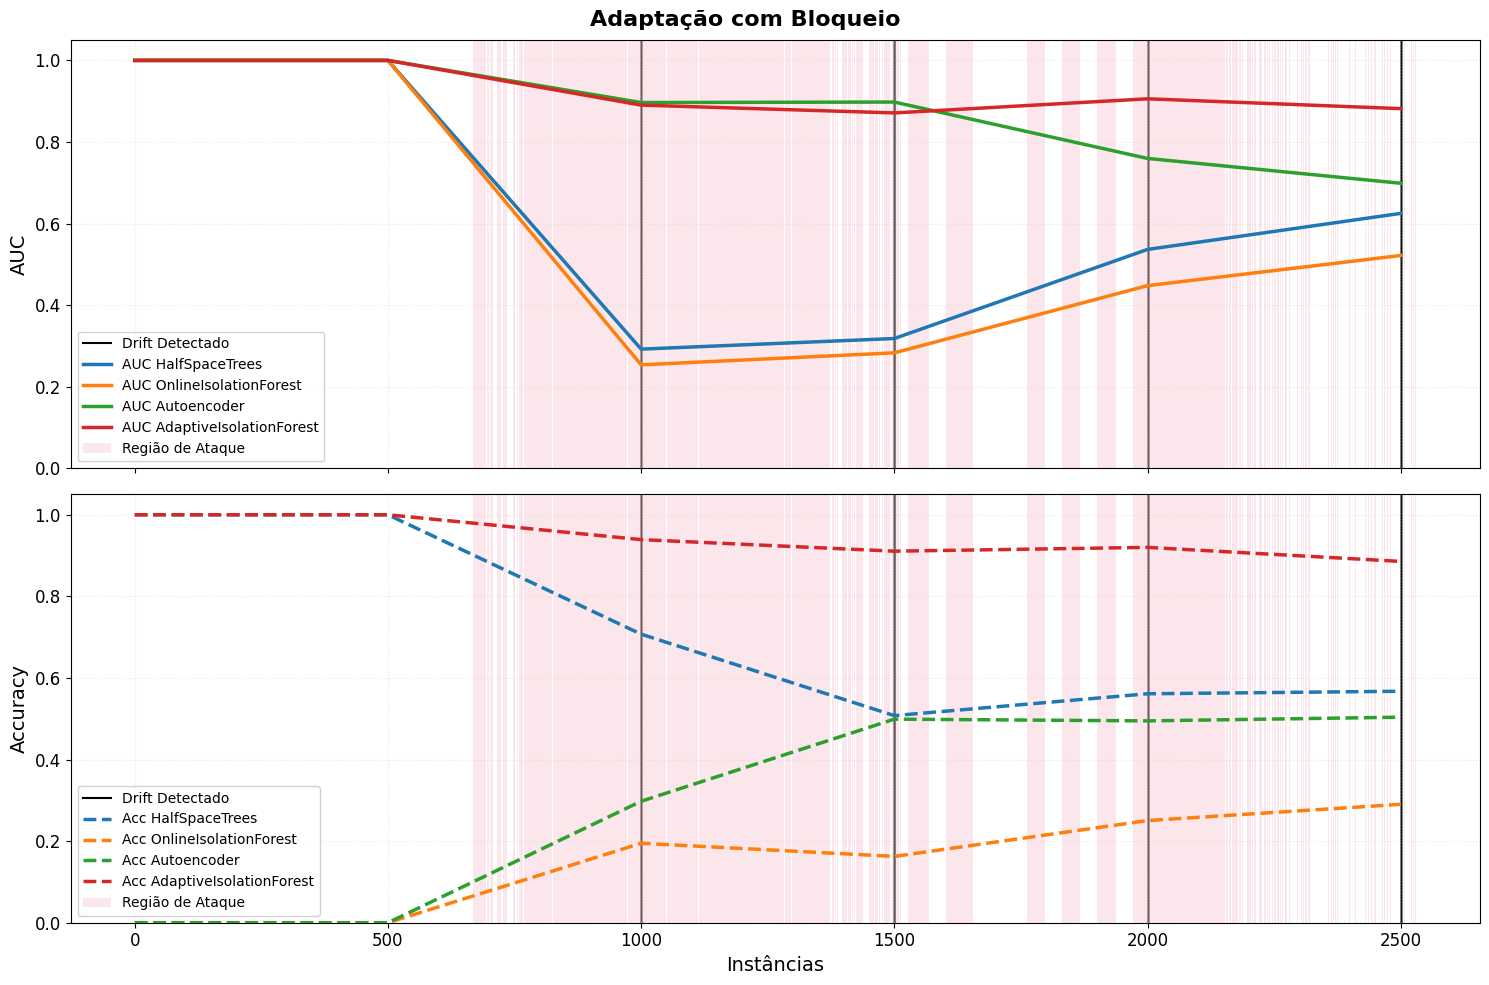

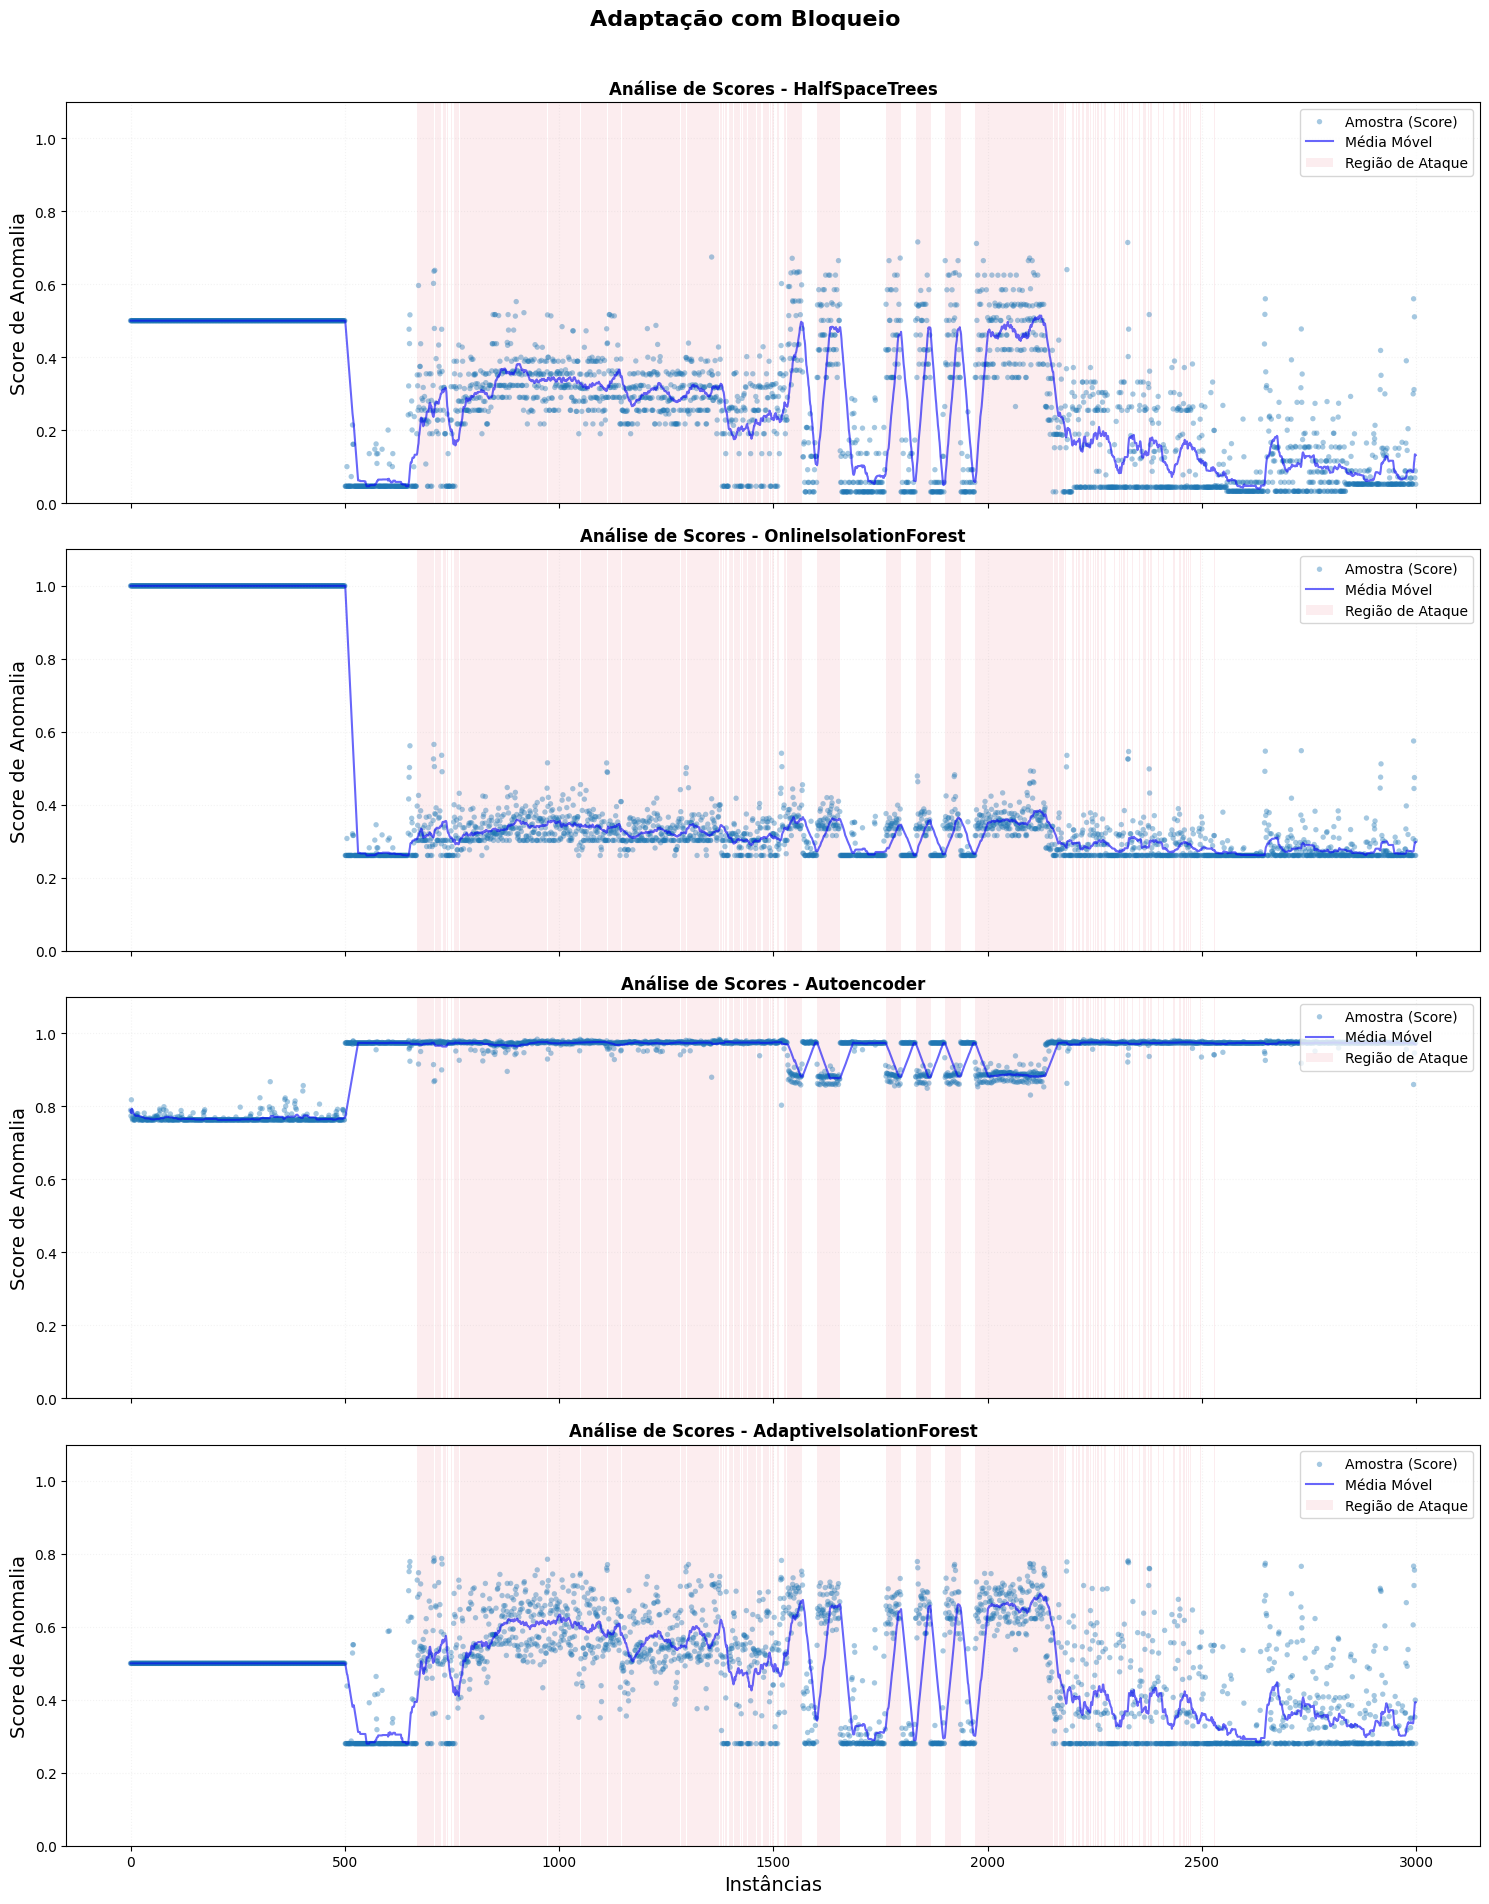

In [2]:
from py.AnomalyDetectionPipeline import AnomalyExperimentRunner
from py.ModelsAnomalyDetection import get_anomaly_models

# Instanciar a classe
runner = AnomalyExperimentRunner()

# Configurar seus algoritmos 
algoritmos = get_anomaly_models(
    stream.get_schema(), 
    selected_models=['AE', 'HST', 'OIF', 'AIF']
)

# Pipeline Adaptativo 
runner.ExecuteExperiments(
    stream=stream,
    pipeline_name='adaptive', # 'adaptive', 'standard', ou 'memory'
    algorithms=algoritmos,
    warmup_windows=1,
    window_size=500,
    anomaly_threshold=0.2,
    beta=0.3,
    title="Adaptação com Bloqueio",
    logging=False
)

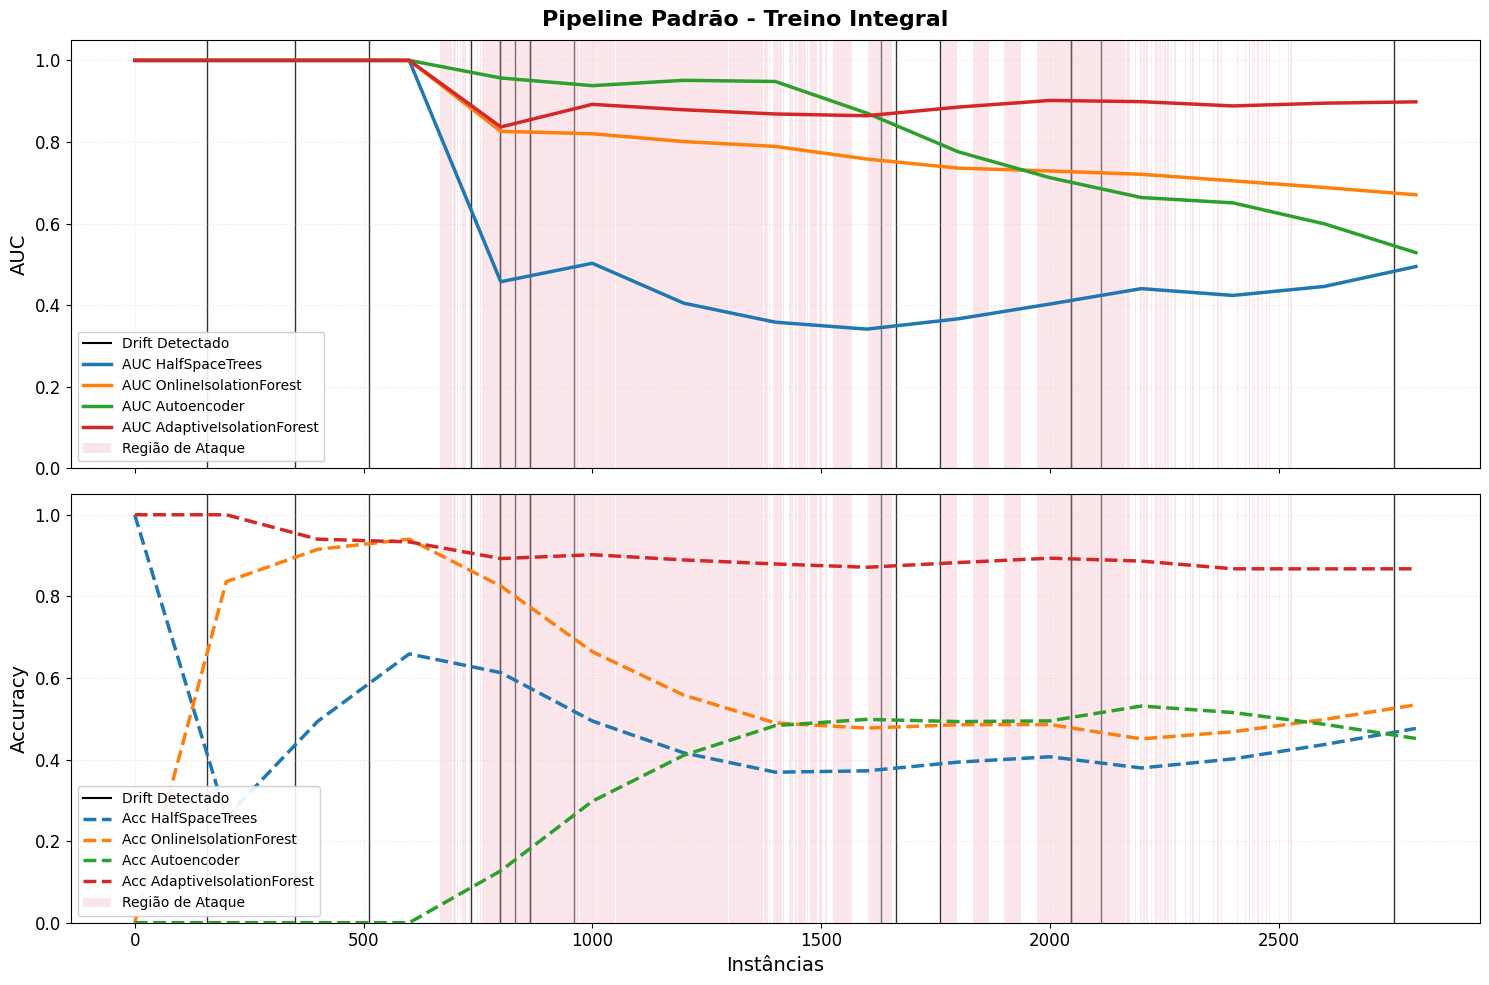

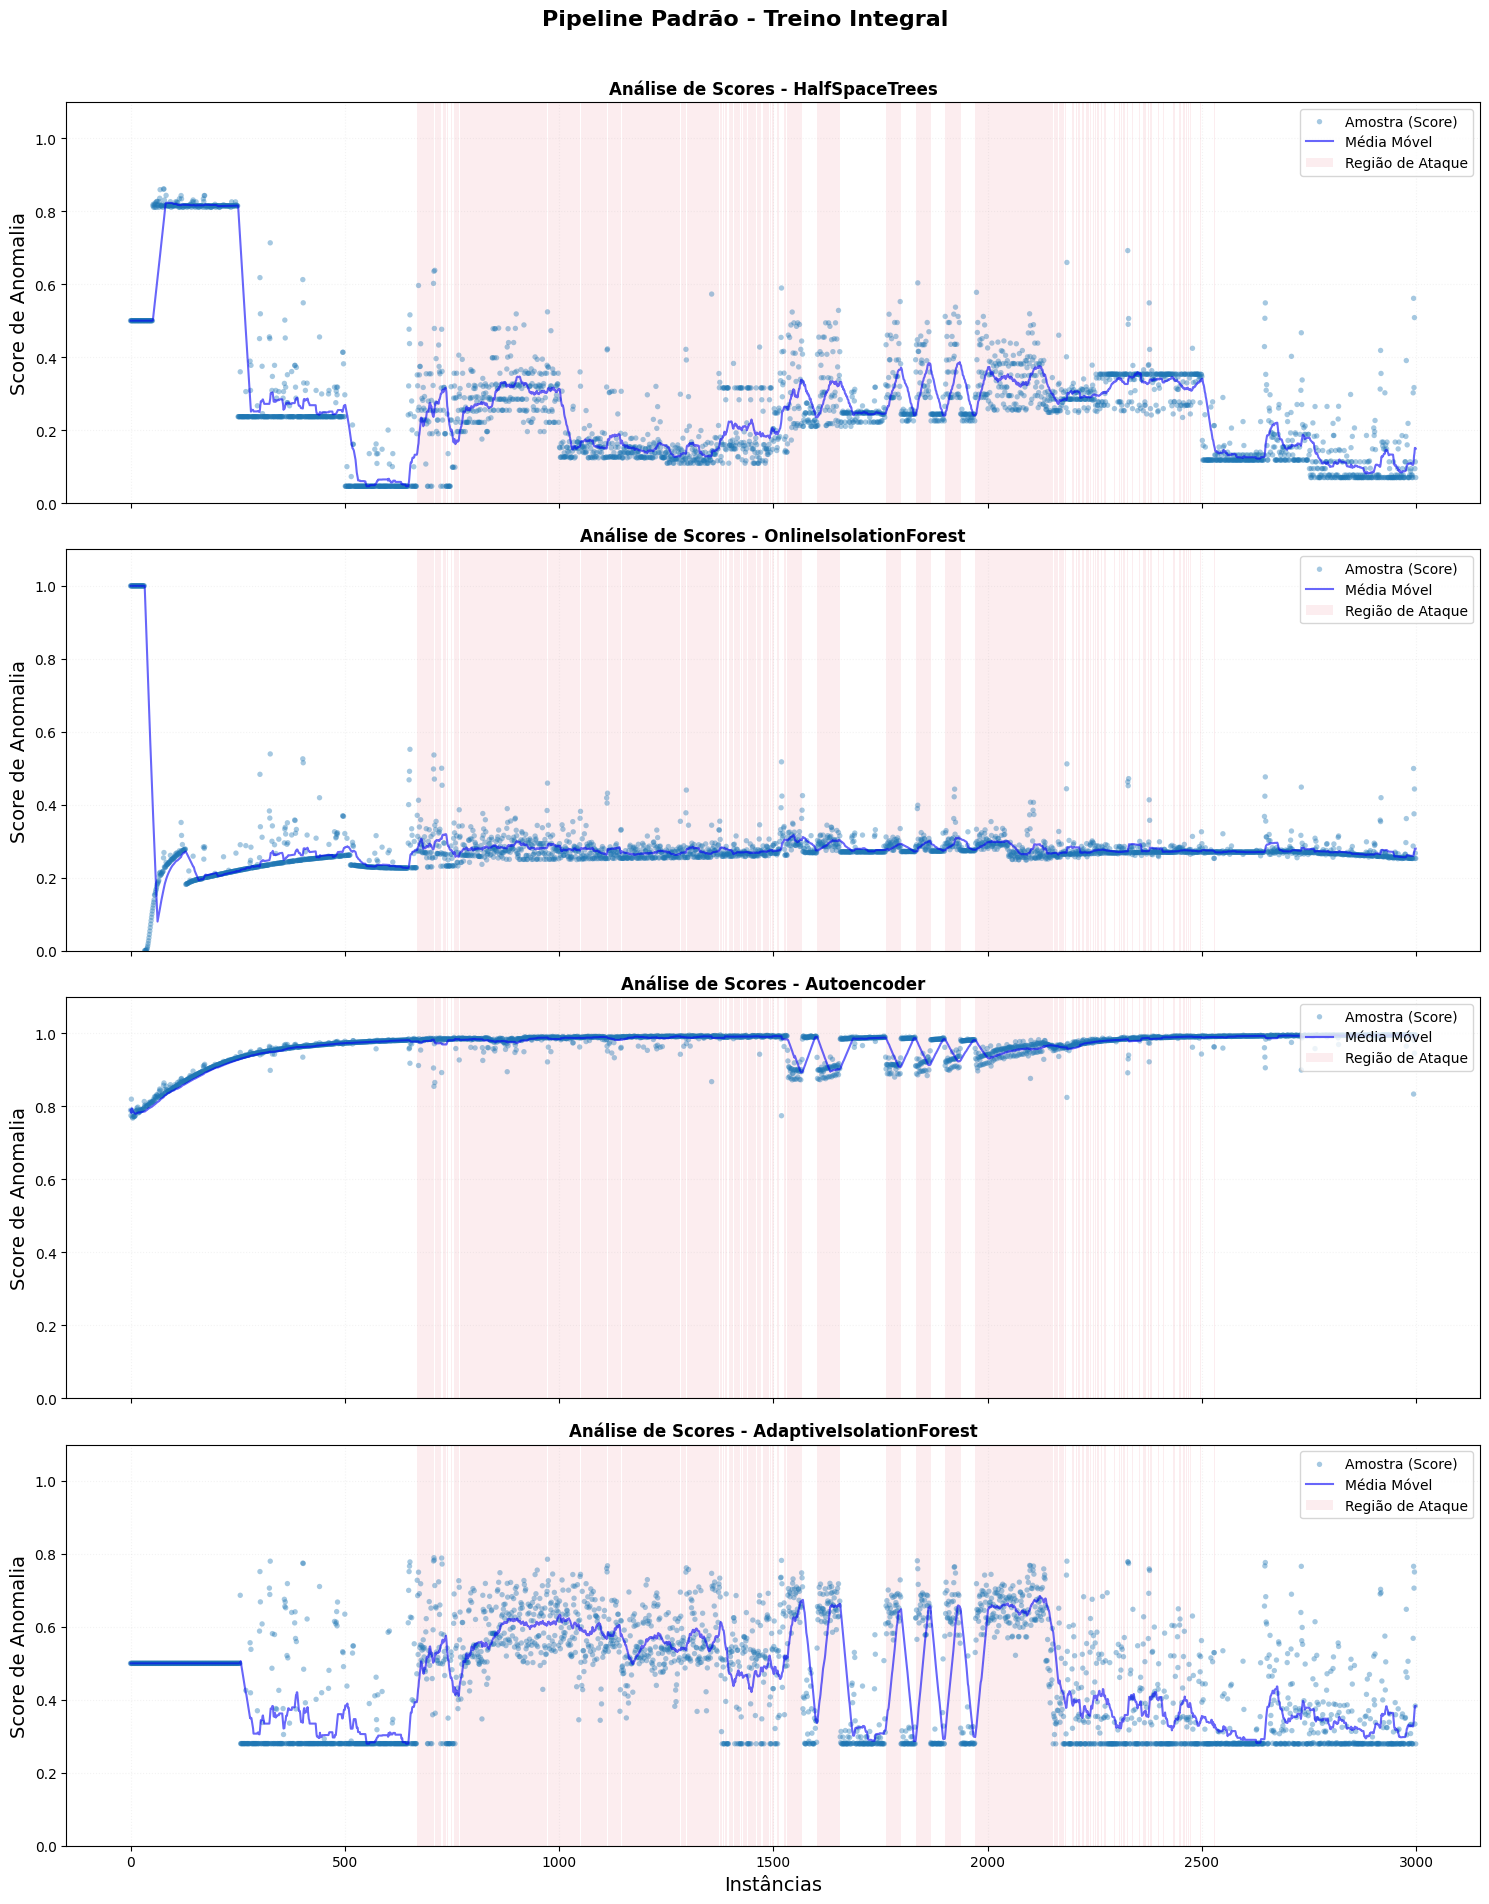

In [3]:
from py.AnomalyDetectionPipeline import AnomalyExperimentRunner
from py.ModelsAnomalyDetection import get_anomaly_models

# Instanciar a classe
runner = AnomalyExperimentRunner()

# Configurar seus algoritmos 
algoritmos = get_anomaly_models(
    stream.get_schema(), 
    selected_models=['AE', 'HST', 'OIF', 'AIF']
)

# Pipeline Padrão 
runner.ExecuteExperiments(
    stream=stream, 
    pipeline_name='standard', 
    algorithms=algoritmos,
    window_size=200, 
    title="Pipeline Padrão - Treino Integral"
)

[HalfSpaceTrees] Instância: 0
  > Novas amostras aceitas: 1 | Histórico: 1
  > Ocupação da Fila: 1/500
[HalfSpaceTrees] Instância: 200
  > Novas amostras aceitas: 201 | Histórico: 201
  > Ocupação da Fila: 201/500
[HalfSpaceTrees] Instância: 400
  > Novas amostras aceitas: 401 | Histórico: 401
  > Ocupação da Fila: 401/500
[HalfSpaceTrees] Instância: 600
  > Novas amostras aceitas: 601 | Histórico: 601
  > Ocupação da Fila: 500/500
  > AVISO: A memória (K=500) foi totalmente renovada 1.2x nesta janela.
[HalfSpaceTrees] Instância: 800
  > Novas amostras aceitas: 790 | Histórico: 790
  > Ocupação da Fila: 500/500
  > AVISO: A memória (K=500) foi totalmente renovada 1.6x nesta janela.
[HalfSpaceTrees] Instância: 1000
  > Novas amostras aceitas: 977 | Histórico: 977
  > Ocupação da Fila: 500/500
  > AVISO: A memória (K=500) foi totalmente renovada 2.0x nesta janela.
[HalfSpaceTrees] Instância: 1200
  > Novas amostras aceitas: 1174 | Histórico: 1174
  > Ocupação da Fila: 500/500
  > AVISO: 

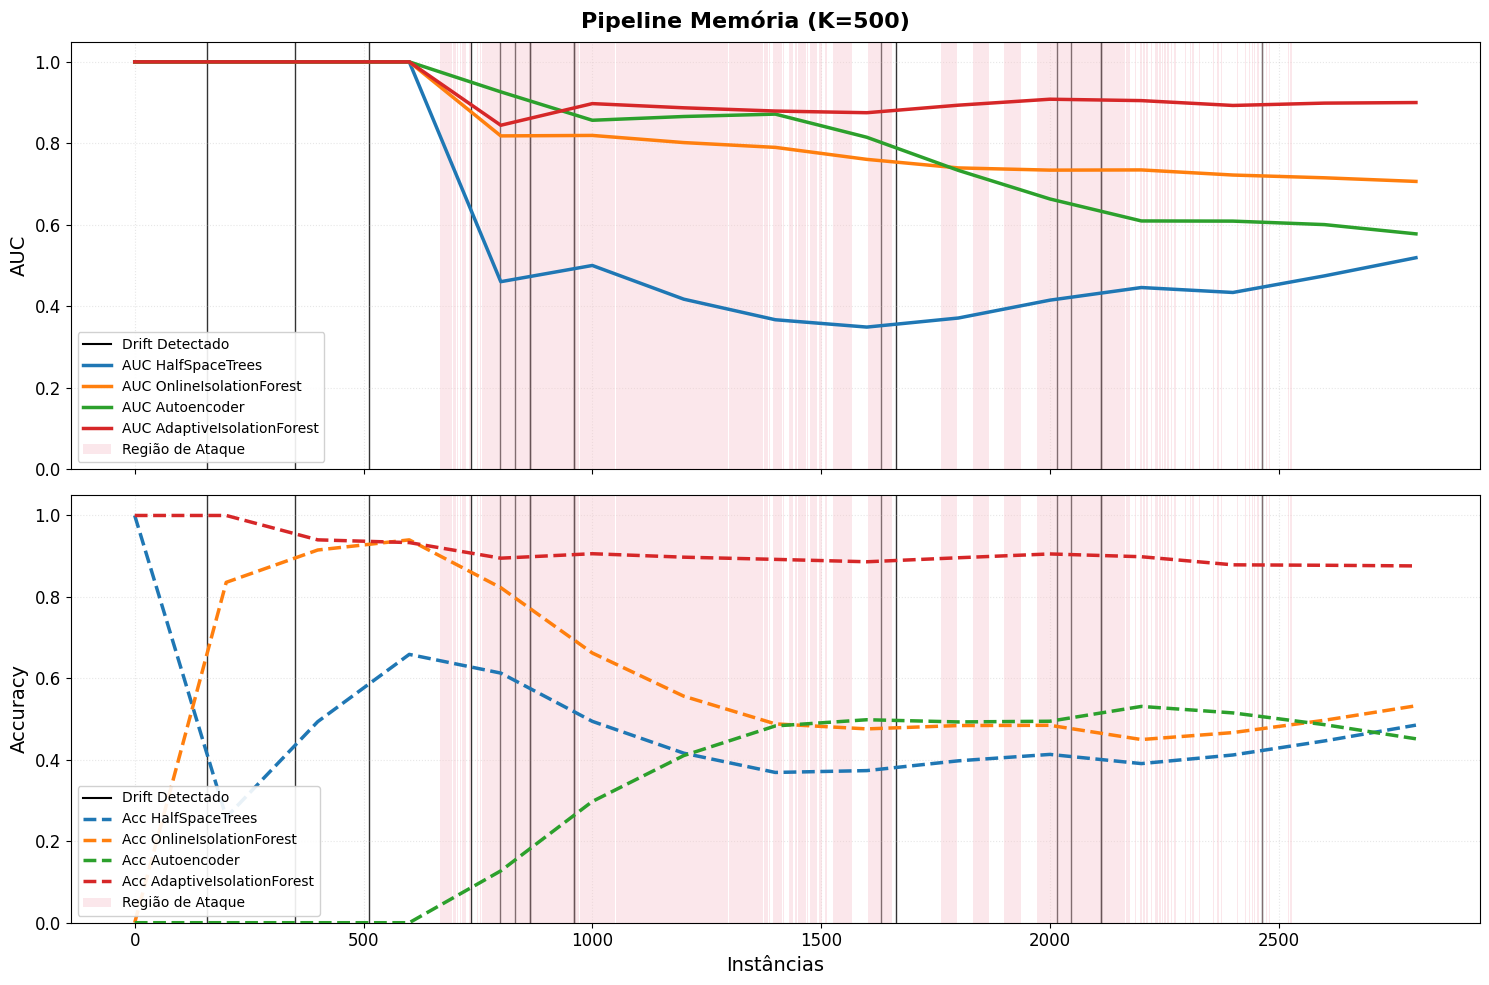

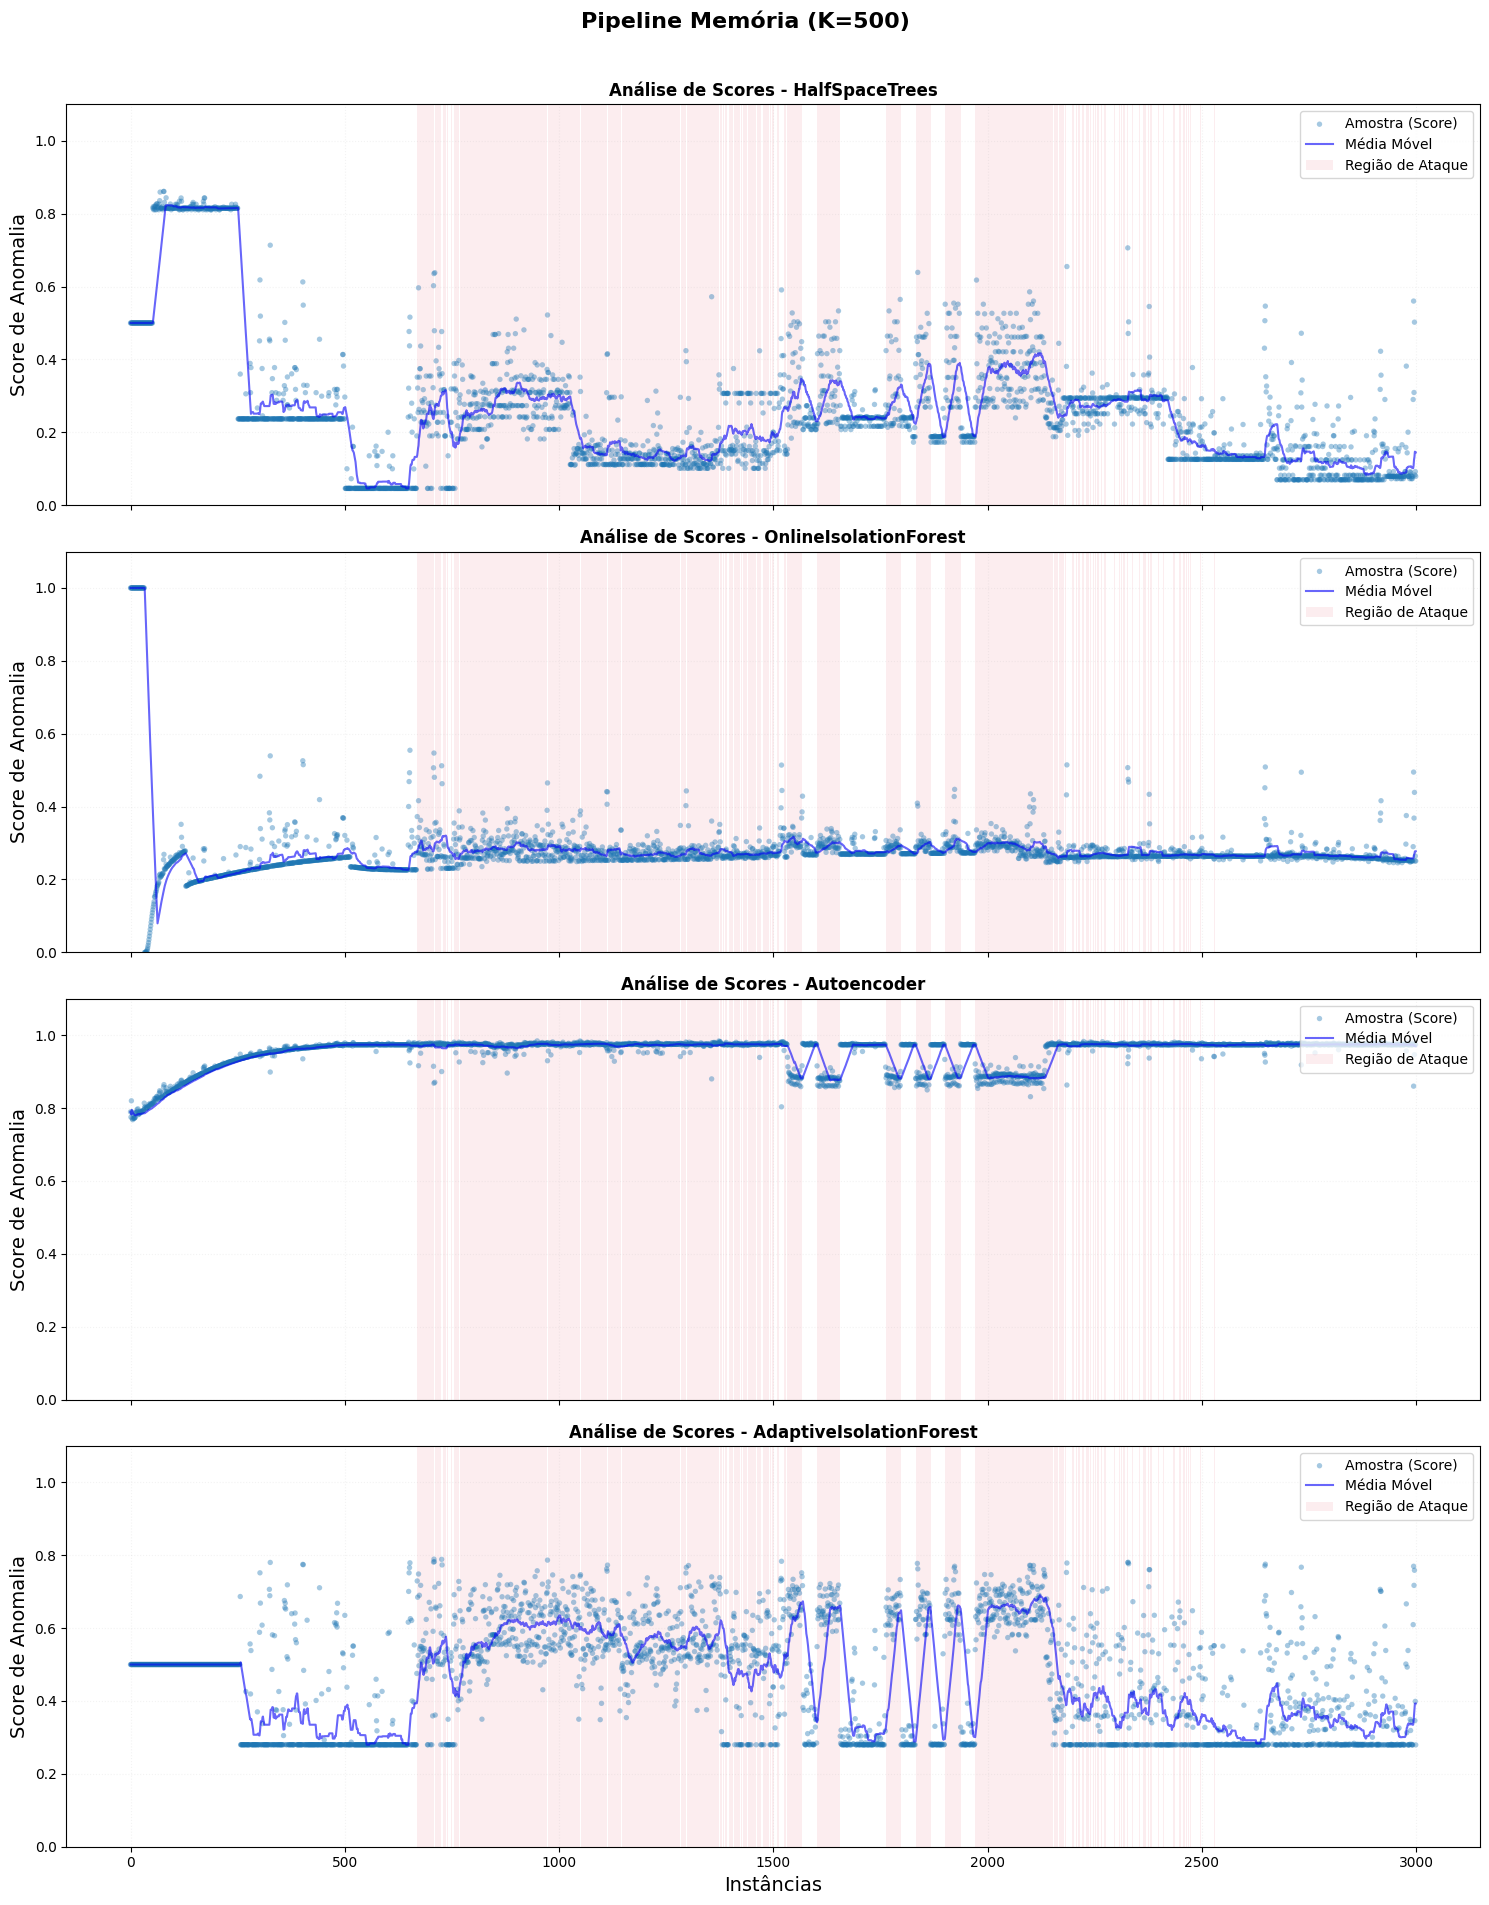

In [4]:
from py.AnomalyDetectionPipeline import AnomalyExperimentRunner
from py.ModelsAnomalyDetection import get_anomaly_models

# Instanciar a classe
runner = AnomalyExperimentRunner()

# Configurar seus algoritmos 
algoritmos = get_anomaly_models(
    stream.get_schema(), 
    selected_models=['AE', 'HST', 'OIF', 'AIF']
)

# Pipeline Memória
runner.ExecuteExperiments(
    stream=stream, 
    pipeline_name='memory', 
    algorithms=algoritmos, 
    K_MEM=500,
    window_size=200, 
    title="Pipeline Memória (K=500)", 
    anomaly_threshold=0.4, 
    logging=False
)